<a href="https://colab.research.google.com/github/Plutooooo/hku_phys3151_2022/blob/main/multivariate-linear-regression/solving_the_Brachistochrone_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving the Brachistochrone problem

In physics and mathematics, a brachistochrone curve (from Ancient Greek βράχιστος χρόνος (brákhistos khrónos) 'shortest time'), or curve of fastest descent, is the one lying on the plane between a point A and a lower point B, where B is not directly below A, on which a bead slides frictionlessly under the influence of a uniform gravitational field to a given end point in the shortest time. The problem was posed by Johann Bernoulli in 1696.
[Wiki](https://en.wikipedia.org/wiki/Brachistochrone_curve)

The image below shows the optimal path in red, along with some slower paths in blue.

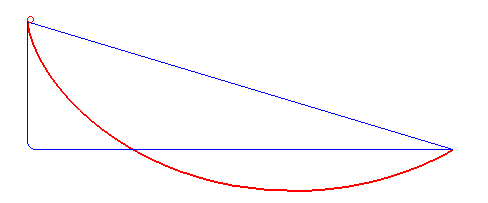

## Theory

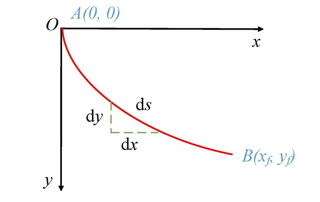

By the conservation of energy, the instantaneous speed of a body $v$ after falling a height y in a uniform gravitational field is given by

 $$v=\frac{ds}{dt}=\sqrt{2gy}$$



Then

$$
dt=\frac{ds}{\sqrt{2gy}}=\sqrt{\frac{dx^{2}+dy^{2}}{2gy}}=\sqrt{\frac{1+y'^{2}}{2gy}}
$$


where $y'=\frac{dy}{dx}$.

So the time between A and B is
$$
t_{A \rightarrow B}=\int_{0}^{x_{f}}\sqrt{\frac{1+y'^{2}}{2gy}}dx
$$

The function to be varied is thus
$$
f=\sqrt{\frac{1+y'^{2}}{2gy}}
$$

To proceed, we normally have to apply the full-blown Euler-Lagrange differential equation
$$
\frac{\partial{f}}{\partial{y}}-\frac{d}{dx}\left(\frac{\partial{f}}{\partial{y'}}\right)=0
$$

However, the function $f(y,y')$ is particularly nice since $x$ does not appear explicitly. Therefore,  $\partial{f}/\partial{x}$, and we can immediately use the Beltrami identity
$$
f-y'\frac{\partial{f}}{\partial{y'}}=C
$$

Then
$$
\frac{\partial{f}}{\partial{y'}}=y'f
$$

Noting that the $y$ in above equation is $y(x)$, so the minimum $t$ about $y(x)$ can be found using Laplace equation, the cycloid solution is 

$$
x=r(\theta-sin\theta)\\
y=r(1-cos\theta)
$$

The parametric equation above is the trajectory of a fixed point on the circle when the circle rolls along a straight line. The radius of the rolling circle is $r$, and the value of $r$ is determined by the coordinate value of the end point B. $\theta$ is called the rolling angle, corresponding to the angle through which the rolling circle has rotated.

## Code

This problem can be approached with gradient descent using [PyTorch](https://pytorch.org/docs/stable/torch.html).

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

#y position of the beginning of the wire, end always at 0
starting_y = 0.25 
#evenly spaced points in x, from 0 to 1
xs = torch.linspace(0,1,25) 
#start with a straight line connecting start to end
ys = torch.linspace(starting_y,0,25, requires_grad=True) 
print(starting_y - ys)

tensor([0.0000, 0.0104, 0.0208, 0.0312, 0.0417, 0.0521, 0.0625, 0.0729, 0.0833,
        0.0938, 0.1042, 0.1146, 0.1250, 0.1354, 0.1458, 0.1563, 0.1667, 0.1771,
        0.1875, 0.1979, 0.2083, 0.2188, 0.2292, 0.2396, 0.2500],
       grad_fn=<RsubBackward1>)


First, we divide the wire into segments with heights $y_{i}$ and calculated the speed at each segment using the height difference from the starting point. Then find the length of the segments using the height differences between points, and calculate the time to reach each point $t_{i}$ by integrating the segment length divided by the speeds.

In [2]:
#calculate the time to get to each point
def times(ys): 
  #find velocity based on height
	vs = torch.sqrt(starting_y - ys) 
  #find y difference
	dys = ys[1:] - ys[:-1] 
  #find x difference
	dx = xs[1]-xs[0] 
  #calculate arc length
	lengths = torch.sqrt(dx.pow(2) + dys.pow(2)) 
  #integrate to find time to each point using midpoint velocity
	return torch.cumsum((2./(vs[:-1]+vs[1:])) * lengths, dim=0) 

In [3]:
#solving for the cycloid solution
def func(theta):
	return (1.-np.cos(theta)) / (theta - np.sin(theta)) - .25

theta = optimize.brentq(func, 0.01, 2*np.pi)
print(theta)

4.376072413012933


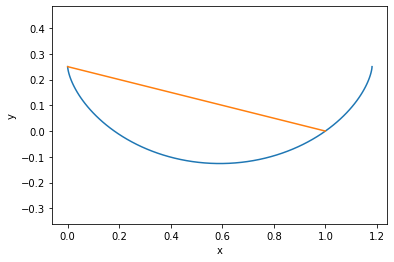

In [4]:
#parameterized cycloid solution
r = 1 / (theta - np.sin(theta))
all_theta = np.linspace(0,2 * np.pi,100)
sol_xs = r * (all_theta-np.sin(all_theta))
sol_ys = starting_y - r * (1-np.cos(all_theta))

#plot the cycloid solution
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sol_xs, sol_ys)
plt.xlabel('x')
plt.ylabel('y')
plt.axis("equal")

#plot the straight line distance of two point
li, = ax.plot(xs.numpy(), ys.detach().numpy())


The blue line in the above figture is the cycloid solution of this problem, and the orange line is the straight line distance of two point $(0,0.25)$ and $(1,0)$. 

Next, we find the derivatives $\frac{dt}{dy}$
 and used gradient descent to find this cycloid solution,  that is to minimize the time to reach the final point.

In [6]:
#gradient descent
#learning rate
lr = 0.005 
for i in range(100):

  #get the times to get to each point
	ts = times(ys)
  #the time to get to the final point
	t = ts[-1]
  #back propagate to find gradients 
	t.backward()
  #hold on to the gradient
	grads = ys.grad 
  
	#update plots
	li.set_xdata(xs.numpy())
	li.set_ydata(ys.detach().numpy())
	fig.canvas.draw()

	#update wire heights
	with torch.no_grad():
		ys[1:-1] = ys[1:-1]-lr * grads[1:-1]
	ys.grad.data.zero_() #zero gradients

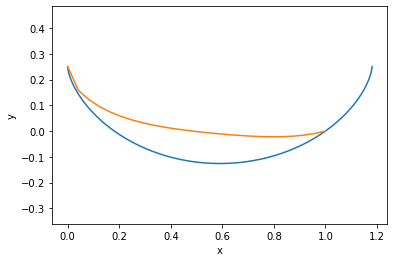

In [7]:
#replot cycloid solution
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sol_xs, sol_ys)
plt.xlabel('x')
plt.ylabel('y')
plt.axis("equal")

#plot the solution of gradient descent
li, = ax.plot(xs.numpy(), ys.detach().numpy())